In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from pathlib import Path

from gym_power_trading.envs import PowerTradingEnv
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

sns.set_theme()

### Formatting function for plot axes

In [6]:
def format_axis_commas(ax, axis):
    """
    Formats the y-axis tick labels to 
    include commas as thousands separators.
    """
    if axis == 'y':
        formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")
        ax.yaxis.set_major_formatter(formatter)
    elif axis == 'x':
        formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")
        ax.xaxis.set_major_formatter(formatter)

In [7]:
def exponential_schedule(initial_lr, decay_rate):
    """
    Exponential decay learning rate schedule.
    Parameters:
        initial_lr (float): The initial learning rate.
        decay_rate (float): The rate of decay, larger values mean more decay.
    Returns: 
        func (object): Function to compute the lr given the fraction of the training completed.
    """
    def func(epoch):
        return initial_lr * np.exp((-decay_rate * epoch))
    return func

#### Callback for logging rewards across parallel environments during Agent training

In [8]:
class VecRewardLogger(BaseCallback):
    """
    Callback for tracking Agent reward progress across training Epochs
    """
    def __init__(self, verbose=0):
        # Reward logging init
        super(VecRewardLogger, self).__init__(verbose)
        self.rewards = []
        self.episode_rewards = None
    
    def _on_training_start(self):
        # Initialize on training start to get the number of environments
        self.episode_rewards = np.zeros(self.model.env.num_envs)

    def _on_step(self) -> bool:
        """ This method is called after each step """
        # Update rewards for all environments
        self.episode_rewards += np.array(self.locals['rewards'])
        # Check if any episode is done
        if np.any(self.locals['dones']):
            avg_episode_reward = np.mean(self.episode_rewards)
            self.rewards.append(avg_episode_reward)
            if self.verbose > 0:
                print("Logged rewards for completed episodes:", [self.rewards[-1]])
        return True  # Always return True to continue training

### Callback for setting learning rate schedule across Epochs

In [9]:
class LearningRateScheduler(BaseCallback):
    """
    Callback for setting agent learning rate schedule across trainig Epochs
    """
    def __init__(self, initial_rate, schedule_func, total_timesteps, epoch_timesteps, verbose=0):
        # LR schedule init
        super(LearningRateScheduler, self).__init__(verbose)
        self.initial_learning_rate = initial_rate
        self.schedule_func = schedule_func
        self.total_timesteps = total_timesteps
        self.epoch_timesteps = epoch_timesteps
    
    def _on_training_start(self):
        # Initialize LR
        self.model.policy.optimizer.param_groups[0]['lr'] = self.initial_learning_rate
    
    def _on_step(self) -> bool:
        # Update LR based on schedule function
        total_steps = self.num_timesteps + self.model._num_timesteps_at_start
        epoch = total_steps // self.epoch_timesteps
        updated_lr = self.schedule_func(epoch)
        self.model.policy.optimizer.param_groups[0]['lr'] = updated_lr
        return True

In [10]:
file_name = "data\AEP_PSGC1_AMP_dart_Oct20.h5"
path = Path(file_name).resolve()
path_string = str(path)
df = pd.read_hdf(path_string)
df.head()

RT_LMP  DA_LMP
MARKET_DAY NODE          TYPE    VALUE HourEnding                
2020-10-01 AEP.PSGC1.AMP Gennode LMP   1            10.02   14.33
                                       2            12.51   13.09
                                       3            12.79   12.96
                                       4            12.53   13.62
                                       5            13.43   14.49

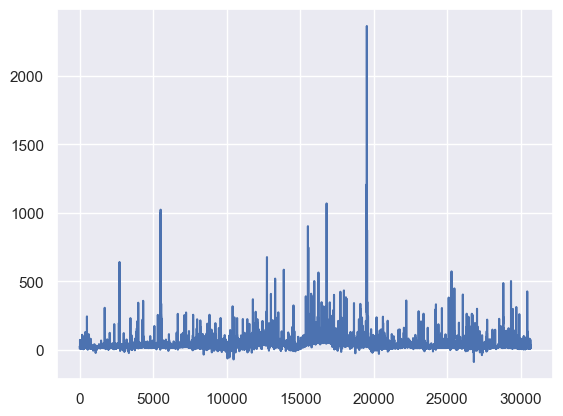

In [7]:
price_values_array = df.RT_LMP.values
plt.plot(price_values_array)

(0.0, 300.0)

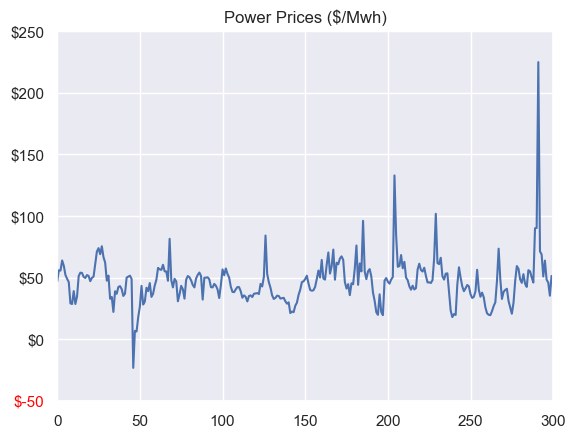

In [8]:
fig, ax = plt.subplots()
ax.plot(price_values_array[18700: 19000])
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.set_title("Power Prices ($/Mwh)")

for label in ax.get_yticklabels():
    value = int(float(label.get_text().replace('$', '').replace(',', '')))
    if value < 0:
        label.set_color('red')

plt.ylim(-50, 250)
plt.xlim(0, 300)

## PPO Agent with Basic Features 

### (4-hr Observation Window, 500,000 training iterations) 

Environment Observation Comprised of:
-  Current Price (\$/Mwh) / DA Price \($/Mwh)
-  Price Difference (from last tick) (%)
-  Battery State of Charge (%)
-  Battery Avg Energy Price (\$/Mwh) / Energy Price Window-period Rolling Avg \($/Mwh)



Rewards: 

    - Log Return of profitable discharges: Revenue / Power Sold * Stored Power Cost Basis 
    - Log of revenue when selling power with negative cost basis: ln(revenue + |Stored Power Cost Basis|)

Penalty:

    - Log return of loss for unprofitable discharges: Revenue / Power Sold * Stored Power Cost Basis 
    - Overcharging (-1)
    - Discharging When Empty (-1)
    - Selling when Power Prices are Negative (2)

In [11]:
%%time
TOTAL_TIMESTEPS = 500_000
VAL_SIZE = 3_000
TRAIN_WINDOW = 720 # hrs (1 month)
WINDOW = 4 # hours
N_ENVS = 4

# Walk forward during training to simulate real environment + reduce agent memorization
num_batches = (df.shape[0] - VAL_SIZE) // TRAIN_WINDOW
batch_timesteps = (TRAIN_WINDOW - WINDOW - 1) * N_ENVS
epoch_timesteps = (num_batches * batch_timesteps)
num_epochs = TOTAL_TIMESTEPS // epoch_timesteps

LR_INITIAL = 1E-4
DECAY_RATE = 0.97
lr_schedule = exponential_schedule(LR_INITIAL, DECAY_RATE)

lr_callback = LearningRateScheduler(LR_INITIAL, lr_schedule, TOTAL_TIMESTEPS, epoch_timesteps)
reward_callback = VecRewardLogger(verbose=1)

# Produce Observations across # n_envs parallel environments 
venv = make_vec_env(lambda: PowerTradingEnv(df=df, window_size=WINDOW, frame_bound=(0, TRAIN_WINDOW)), n_envs=N_ENVS) 

PPO_power_basic = PPO(
    'MlpPolicy', 
    venv, 
    gamma=0.99,
    device='cpu', 
    learning_rate=LR_INITIAL, 
    normalize_advantage=True
)

for epoch in range(num_epochs):
    for i in range(num_batches):
        start_day = i * TRAIN_WINDOW
        end_day = start_day + TRAIN_WINDOW
        venv.env_method('set_frame_bound', start_day, end_day) # Set venvs frame bounds
        # Learn on currrent minibatch
        PPO_power_basic.learn(total_timesteps=batch_timesteps, callback=[reward_callback, lr_callback], reset_num_timesteps=False)

c:\users\andrew deur\documents\nyu\ds-ga 3001 reinforcement learning\3001-rl-grid-battery-management-agent\gym-power-trading\gym_power_trading\envs\power_trading.py:205: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Change from price 1-tick ago
c:\Users\Andrew Deur\anaconda3\envs\rl_project\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.set_frame_bound to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_frame_bound` for environment variables or `env.get_wrapper_attr('set_frame_bound')` that will search the reminding wrappers.
  logger.warn(


Logged rewards for completed episodes: [-412.45864280313253]
Logged rewards for completed episodes: [-860.3181708246586]
Logged rewards for completed episodes: [-326.80567787215114]
Logged rewards for completed episodes: [-684.6977764323342]
Logged rewards for completed episodes: [-260.3917472809553]
Logged rewards for completed episodes: [-580.8706137500703]
Logged rewards for completed episodes: [-235.62468857690692]
Logged rewards for completed episodes: [-384.84334480989537]
Logged rewards for completed episodes: [-22.911483373492956]
Logged rewards for completed episodes: [-33.28898899623891]
Logged rewards for completed episodes: [231.06759487837553]
Logged rewards for completed episodes: [426.2514715924624]
Logged rewards for completed episodes: [-73.10899881125533]
Logged rewards for completed episodes: [-110.15535062403524]
Logged rewards for completed episodes: [-19.64759311825037]
Logged rewards for completed episodes: [-43.9288042075932]
Logged rewards for completed episode

### Episode Reward Progression

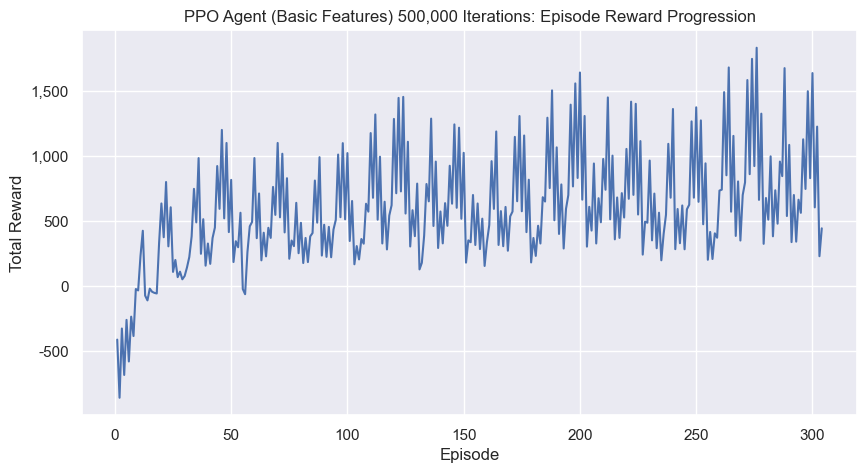

In [12]:
num_eps = np.arange(1, len(reward_callback.rewards) + 1)

fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'y')
ax.plot(num_eps, reward_callback.rewards)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Agent (Basic Features) 500,000 Iterations: Episode Reward Progression')
plt.show()

### Plot of Agent Trades in Held out test set

c:\users\andrew deur\documents\nyu\ds-ga 3001 reinforcement learning\3001-rl-grid-battery-management-agent\gym-power-trading\gym_power_trading\envs\power_trading.py:205: RuntimeWarning: divide by zero encountered in divide
  pct_diff = np.insert(np.where(prices[:-1] != 0, diff / prices[:-1], 0), 0, 0) # Change from price 1-tick ago


[]

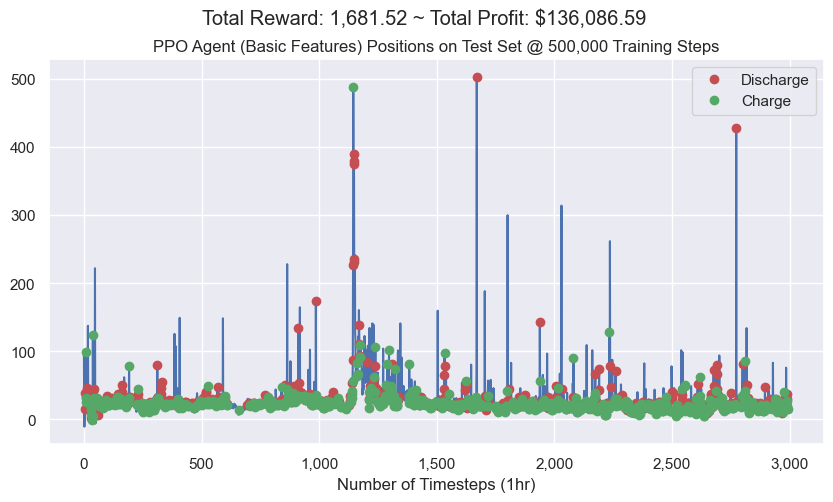

In [13]:
window = 4
last_index = len(df) - 10
start_index = last_index - VAL_SIZE
env = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env.reset()
obs = obs[0]

for i in range(last_index - start_index):
    action, states = PPO_power_basic.predict(obs, deterministic=True)
    obs, rewards, term, trunc, info = env.step(action)
    if term or trunc:
        history = env.history
        env.render_all(title="PPO Agent (Basic Features) Positions on Test Set @ 500,000 Training Steps")
        env.reset()

plt.xlabel("Number of Timesteps (1hr)")
plt.plot()

### Reward Statistics over 100 Episodes

### Reward Evolution on Held Out Data

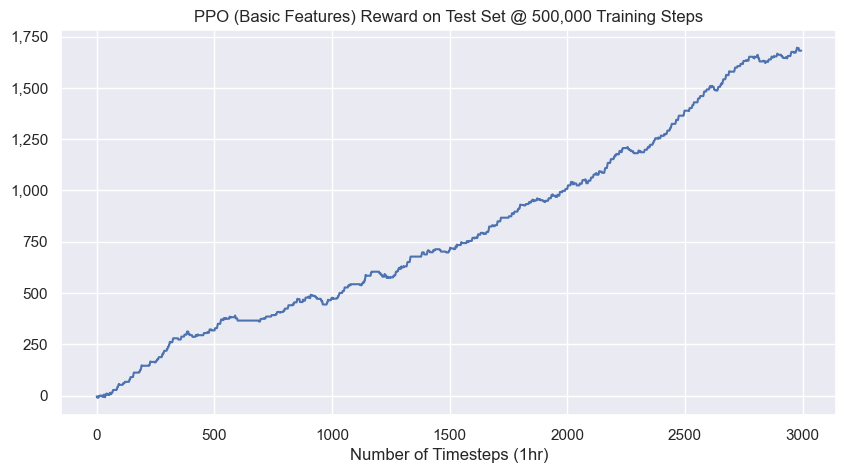

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'y')
ax.plot(history['total_reward'])

plt.title("PPO (Basic Features) Reward on Test Set @ 500,000 Training Steps")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Battery Charge Management

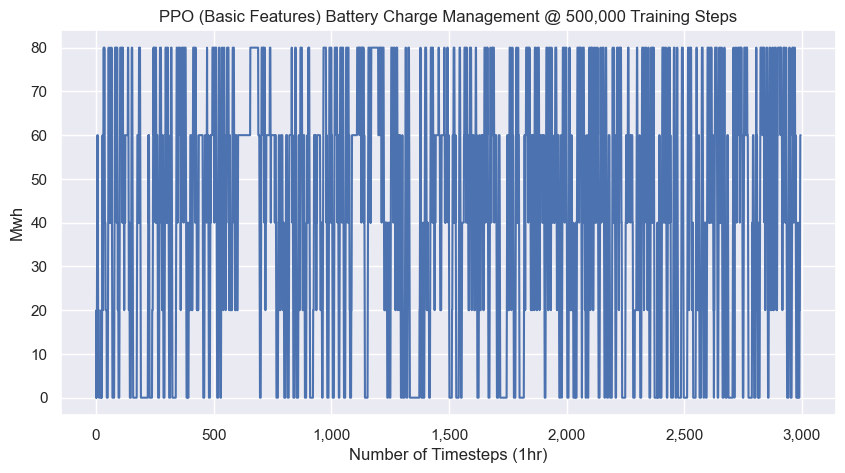

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'x')
ax.plot(history['battery_charge'])

plt.title("PPO (Basic Features) Battery Charge Management @ 500,000 Training Steps")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

### Profit Evolution on Held Out Data

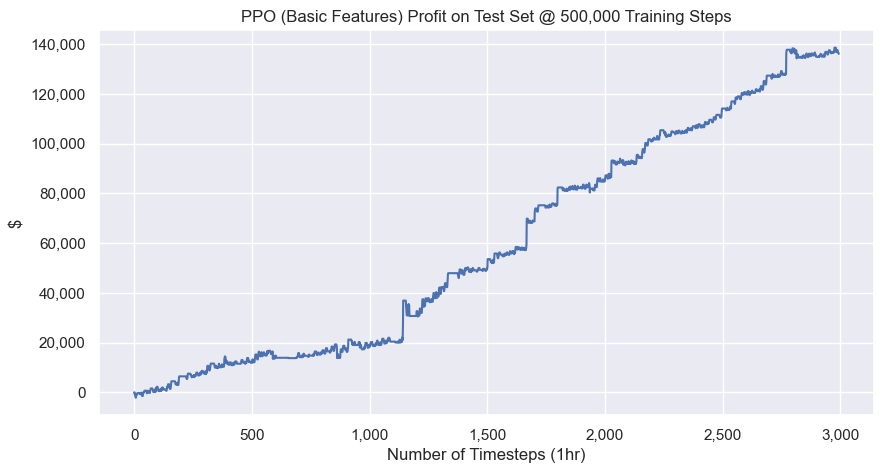

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
format_axis_commas(ax, 'y')
format_axis_commas(ax, 'x')
ax.plot(history['total_profit'])

plt.title("PPO (Basic Features) Profit on Test Set @ 500,000 Training Steps")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

In [15]:
PPO_power_basic.save('PPO_power_basic_500k')